In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json

from os import listdir

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown 1IH84zerloTZGNF33Kbj1-5IoGTNFAolR
!gdown 1MXZT_Pmxm6e1L0NLRRBf5D9NayDaiT5a

In [ ]:
!gdown 1-OmS1dYwi1If2GPRVbhmGgPvDCy2jDSF

In [ ]:
!mkdir train
!unzip train_dataset_mc.zip -d train
!unzip test_dataset_mc2.zip

In [3]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")

        self._image_files = [i for i in self._image_files if glob.glob(i.replace("png", "geojson"))]

        # with open("image_files.txt") as f:
        #     files = f.read()
        # files = files.split(', ')

        # self._image_files = ['/content/train/' + file for file in files]
        

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.int32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]:
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0)
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.int32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask |= EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask |= EyeDataset.parse_polygon(coordinates, image_size)
        # print(np.unique(mask))
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        mask = self.read_layout(json_path, image.shape[:2])

        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)

In [4]:
# Задаем преобразование изображений
# 1024, 777
size = 1600
train_list = [# A.augmentations.transforms.Normalize(max_pixel_value=1.0),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size),
             A.PadIfNeeded(size, size),
             # A.augmentations.transforms.Normalize(max_pixel_value=1.0),
             ToTensorV2(transpose_mask=True),
             ]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}

In [5]:
dataset = EyeDataset("/content/train")

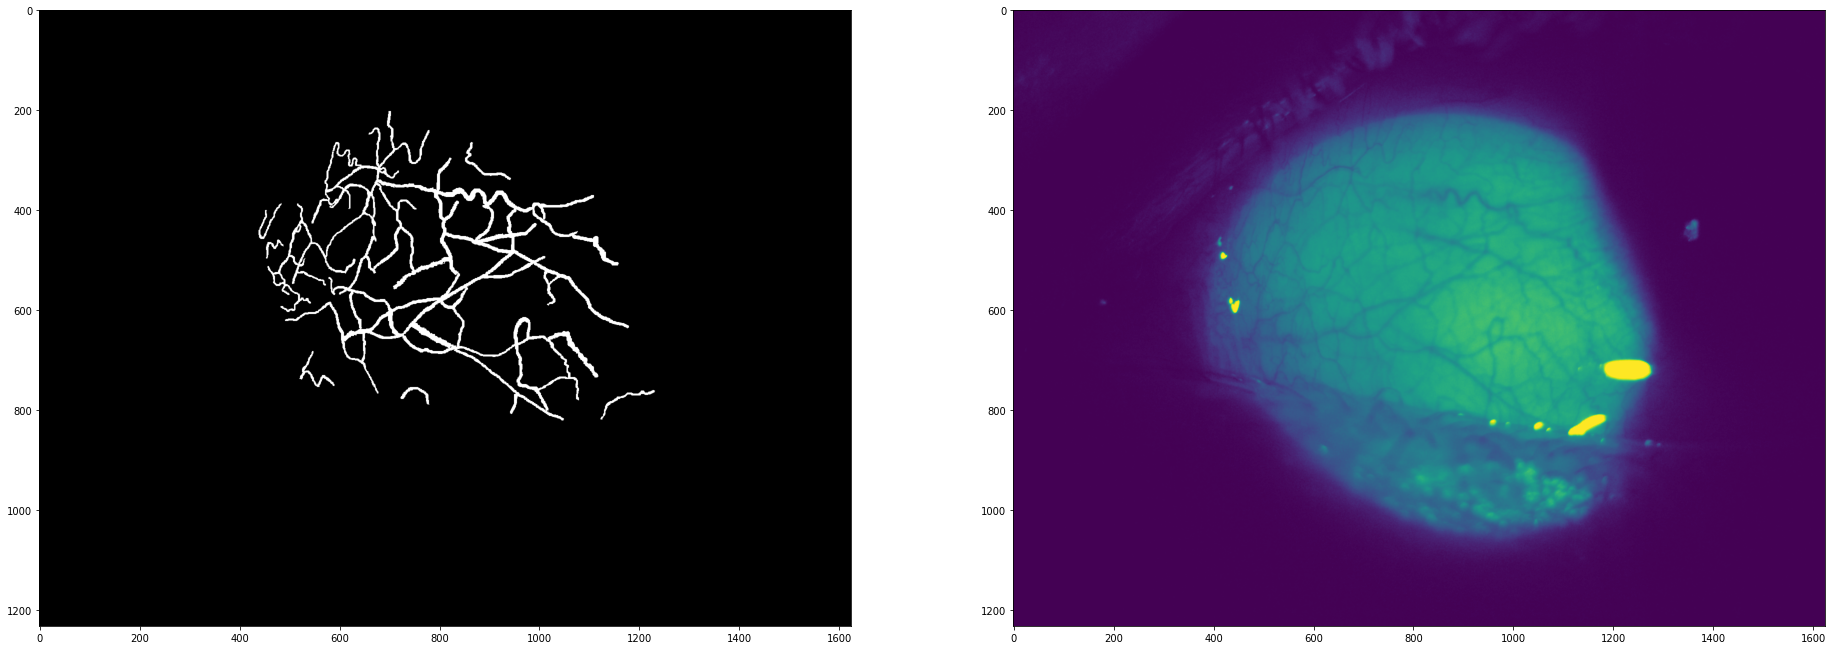

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(32,16))

i = 59
axs[0].imshow(dataset[i]['mask'][:, :, 1], cmap="gray")
axs[1].imshow(dataset[i]['image'][:, :, 1])

In [7]:
model = smp.UnetPlusPlus('resnext50_32x4d', activation='logsoftmax', classes=2, encoder_weights=None).cuda()


model.load_state_dict(torch.load('unet++_resnext50_1600_8.pt'))

<All keys matched successfully>

In [8]:
submission_transforms = A.Compose(
    [A.CenterCrop(width=1600, height=1214),
     A.LongestMaxSize(1624)]
)

# submission_transforms = A.Compose(
#     [A.CenterCrop(width=512, height=388),
#      A.LongestMaxSize(1624, interpolation=cv2.INTER_CUBIC)]
# )

In [9]:
torch.cuda.empty_cache()

In [10]:
!mkdir final_5_8

In [11]:
import gc

In [12]:
from torchvision.transforms import ToPILImage
import copy

model.eval()

for img_name in tqdm(listdir("/content/eye_test")):
    torch.cuda.empty_cache()
    image = EyeDataset.read_image("/content/eye_test/" + img_name)
    image_tta_0 = cv2.flip(image.copy(), 0)
    image_tta_1 = cv2.flip(image.copy(), 1)
    image_tta_2 = cv2.flip(image.copy(), -1)
    transformed = transforms['test'](image=image)
    transformed_tta_0 = transforms['test'](image=image_tta_0)
    transformed_tta_1 = transforms['test'](image=image_tta_1)
    transformed_tta_2 = transforms['test'](image=image_tta_2)
    image = transformed["image"]
    image_tta_0 = transformed_tta_0["image"]
    image_tta_1 = transformed_tta_1["image"]
    image_tta_2 = transformed_tta_2["image"]
    image = image.to('cuda')
    image_tta_0 = image_tta_0.to('cuda')
    image_tta_1 = image_tta_1.to('cuda')
    image_tta_2 = image_tta_2.to('cuda')
    with torch.no_grad():
        prediction = model(image.unsqueeze(dim=0))
        prediction_tta_0 = model(image_tta_0.unsqueeze(dim=0))
        prediction_tta_1 = model(image_tta_1.unsqueeze(dim=0))
        prediction_tta_2 = model(image_tta_2.unsqueeze(dim=0))
    # pred_ask = (torch.exp(prediction[0]) > 0.5).cpu().to(torch.uint8).detach().numpy()
    pred_ask = (torch.exp(prediction[0])).cpu().detach().numpy()
    pred_ask_tta_0 = (torch.exp(prediction_tta_0[0])).cpu().detach().numpy()
    pred_ask_tta_1 = (torch.exp(prediction_tta_1[0])).cpu().detach().numpy()
    pred_ask_tta_2 = (torch.exp(prediction_tta_2[0])).cpu().detach().numpy()
    pred_ask = (pred_ask[1] + cv2.flip(pred_ask_tta_1[1], 1) + cv2.flip(pred_ask_tta_0[1], 0) + cv2.flip(pred_ask_tta_2[1], -1)) / 4
    # pred_ask = (pred_ask > 0.5).astype(np.uint8)
    pred_ask = submission_transforms(image=pred_ask)["image"]
    pred_ask *= 255
    mask = Image.fromarray(pred_ask)
    mask = mask.convert("L")
    mask.save("final_5_8/" + img_name)
    gc.collect()

100%|██████████| 301/301 [24:36<00:00,  4.90s/it]


In [13]:
np.unique(pred_ask)

array([1.9116573e-07, 2.2808901e-07, 2.3127399e-07, ..., 2.5499997e+02,
       2.5499998e+02, 2.5500000e+02], dtype=float32)

In [14]:
%cd final_5_8

/content/final_5_8


In [ ]:
!zip -r final_5_8.zip *.png

In [17]:
!mv final_5_8.zip ../final_5_8.zip